
## I) Data preprocessing
	1) Celaning data
	2) Merging datasets
    3) Scaling the data
    4) Splitting into train and test data
	5) Dealing with imbalanced data
    
## II) Reducing the number of features
	
    1) Feature selection - dropping constant features
    2) Feature Selection base on Correlation
    3) Feature Selection-Information gain - mutual information In Classification Problem
    4) Feature Selection base on variance
    5) Feature selection based on Variance inflation factor
    6) Feature selection based on Permutation importance (model based)
    

    
## III) Training the models and fine tuning 
	- Logistic Regression
	-  Random Forest
	-  XGBoost
	-  SVC
    
## IV) Evaluating the best  model 
    - AUC_ROC curve for SVC model
    - Confusion matrix
    - F beta scores calculation
    - F beta scor for an increasing threshold of predcitions probabilities
    - Optimizing the False négatives (Bank costs function of predicition probabilities)
    
## V) Interpretability of the choisen model (SVC)
	1) Global interpretability
	2) ILocal interpretability
    
## VI) Neural Networks model



In [1]:
# The imports
import numpy as np
import pandas as pd

import gc
import re
import time
import dill 
import seaborn as sns
import scipy.stats as st
from contextlib import contextmanager


import lime
from lime import lime_tabular
import missingno as msno

import joblib
from joblib import dump, load
from keras.models import Sequential
from keras.layers import Dense
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

import sklearn
from sklearn import metrics
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.metrics import confusion_matrix , classification_report
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from statsmodels.stats.outliers_influence import variance_inflation_factor


In [ ]:
# Loading data
df_application_test = pd.read_csv('application_test.csv')
df_application_train = pd.read_csv('application_train.csv')
df_bureau_balance = pd.read_csv('bureau_balance.csv')
df_bureau = pd.read_csv('bureau.csv')
df_credit_card_balance = pd.read_csv('credit_card_balance.csv')
df_installments_payments = pd.read_csv('installments_payments.csv')
df_POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
df_previous_application = pd.read_csv('previous_application.csv')

In [ ]:
# # Load data after all preprocessing steps
# X_training = pd.read_csv('./X.csv')
# y_training = pd.read_csv('./y_resampled.csv')

# X_testing = pd.read_csv('./X_testing.csv')
# y_test= pd.read_csv('./y_test.csv')

In [2]:
# display all columns and rows of a dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
# See what every dataset in terms of 'nb_values', 'missing_values', 'filling_rate', 'data_type' and  'shape'

def columns_filling_rate(dataframe, columns='all', missing_only=False):
    """Calculate and displays the filling rate for
    a particular column in a pd.DataFrame."""
    
    # Importations
    import pandas as pd
    import numpy as np
    
    
    # If 'feature' is not specified
    if columns == 'all':
        columns = dataframe.columns
         
    # initialization of the results DataFrame
    results = pd.DataFrame(columns=['nb_values', 'missing_values', 'filling_rate', 'data_type', 'shape'])
        
    # for each feature
    for column in columns:

        # Count of the values on each column
        values_count = dataframe[column].count()
        
        # Computing missing values
        nb_rows = dataframe.shape[0]
        missing_values = nb_rows - values_count

        # Computing filling rates
        filling_rate = values_count / nb_rows
        if missing_only and missing_values == 0:
            filling_rate = np.nan
            
         # Adding dtypes of variables
        data_type = dataframe[column].dtypes
        
        shape = dataframe.shape 
        # Adding a row in the results' dataframe
        results.loc[column] = [values_count, missing_values, filling_rate, data_type, shape]
            
    # Sorting the features by number of missing_values
    results = results.dropna(subset=['filling_rate'])
    results = results.sort_values('filling_rate')
    
    if results.empty == False:
        return results     
    else:
        print("No missing value.")

In [ ]:
# drop columns with more than 20% null values

def data_empty_columns_dropper (dataframe, columns=None):
    df = dataframe.dropna(thresh = dataframe.shape[0]*0.8, how = 'any', axis = 1)
    if columns is not None:
        df = df.drop(columns)
    return df

In [ ]:
# For the rest of empty values , replace them with the modal value
def detect_nulls_and_impute(dataframe):
    
    dataframe = data_empty_columns_dropper (dataframe) # We drop columns of filling rate inferior to 80%
    empty_columns = dataframe[dataframe.columns[dataframe.isnull().any()]] # Define the columns that still have missing values
    for col in empty_columns:
        mode_values = empty_columns.mode().to_dict('records')[0] # Impute these columns with the modal value of each colum with missing values the [0] extracts the dictionary from the list
        dataframe.fillna(value=mode_values, inplace = True)
       

    return dataframe

In [ ]:
# # Function to impute missing values with the mean
# def missing_value_imputer(df, columns):
#     for col in columns:
#         df[col].fillna(df[col].mean(), inplace = True)
#         #print(df.isnull().sum())
#     return df

In [ ]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

## We are going to creat a function for every dataset to preprocess them .
### This function will do the following:
    - Read the data
    - Display the length of the data
    - Merge the data with a similar dataset
    - Encode categorical features ( Binary and One-Hot encoding)
    - Missing values imputation and droping
    - performe aggregations ( = for numerical columns calculate values like mean, min, max, size, so that we will have this many categories inside the column)
    - Creat some new features
    - Return a new preprocessed dataframe

In [ ]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = True):
    # Read data and merge
    df =  pd.read_csv('application_train.csv') 
    test_df =pd.read_csv('application_test.csv')
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))  # print the length of datasets
    df = df.append(test_df).reset_index()  # Add test dataset to the train dataset
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    df = data_empty_columns_dropper(df) # dropping columns with at least 20% empty values
    df = detect_nulls_and_impute(df) # imputing the rest of the empty values with the modal values
    
    # Categorical features: Binary features and One-Hot encoding
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:  # These are the features where we have 2 subcategories each a and b 
        df[bin_feature], uniques = pd.factorize(df[bin_feature]) #  the factorize method asigns a number to each unique value of the above 3 columns 
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    
    del test_df
    gc.collect()
    
    
    
    return df

In [ ]:
df_train_test = application_train_test()

In [ ]:
# Save the data
df_train_test.to_csv('./df_train_test.csv')

In [ ]:
# Read the data
df_train_test = pd.read_csv('./df_train_test.csv')

In [ ]:
import missingno as msno
# Visualize missing values as a matrix
msno.matrix(df_train_test)

In [ ]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows) # ??? num_rows
    bb =pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category) # bb  is the dataframe and bb_cat are the colums created of categorical values 
                                                    # (='STATUS' columns of bb) after one hot encoding
        
    
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category) # same here
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']} # Creat a dictionary 
    for col in bb_cat:
        bb_aggregations[col] = ['mean'] # 3 column names  of 'MONTHS_BALANCE' are created here : 'MONTHS_BALANCE' min
                                        #  'MONTHS_BALANCE' max, 'MONTHS_BALANCE' size
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations) # here we perform the calculation with agg methode for min, max and size columns of 'MONTHS_BALANCE
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()]) # Change the multilevel index into one single column name
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU') # The 2 dataframes Bureau and burea balance are joined on 'SK_ID_BUREAU' which is the loan made by every client, many loans are possible for one client
    bureau.drop(columns= 'SK_ID_BUREAU', inplace= True) #" We no longer need the 'SK_ID_BUREAU' column"
    del bb, bb_agg # deleting the unnecessary data 
    gc.collect()  # collecting the garbage
    
    # Bureau and bureau_balance numeric features
    # This dictionary contains all the names of the numerical columns from the bureau dataframe and the aggregations that will be performed on each one of them 
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean'],
        'AMT_ANNUITY': ['max', 'mean'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    # Constructing a dictionary for categorical columns for the bureau and bureau balance dataframes, 
    # that contains the names of the categorical columns along with the aggregations
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean'] # aggregations for categoricals columns of bureau dataframe that we obtained after one hot encoding
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']# aggreg for bb_cat the bureau_balance dataframe after one hot encoding
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations}) # We group by clients ID SK_ID_CURR = one row per client
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()]) # change the multi index naming to have one single name for every formed column
#     # Bureau: Active credits - using only numerical aggregations
#     active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1] # filter the data in bureau dataframe by selecting the active credit clients
#     active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations) # make the aggregations for numerical columns for all the active clients
#     active_agg.columns = pd.Index(['ACT_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()]) # from multi-indexing make one single name per column
#     bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR') # 
#     del active, active_agg
#     gc.collect()
#     # Bureau: Closed credits - using only numerical aggregations
#     closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
#     closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
#     closed_agg.columns = pd.Index(['CLS_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
#     bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
#     del closed, closed_agg, bureau
#     gc.collect()
    
    # Dealing with NaN values
    bureau_agg = data_empty_columns_dropper (bureau_agg) # We drop columns of filling rate inferior to 80%
    bureau_agg = detect_nulls_and_impute(bureau_agg)
    
#     empty_columns = bureau_agg.columns[bureau_agg.isnull().any()] # Define the columns that still have missing values
#     for col in empty_columns: # Impute these columns with the mean value 
#         bureau_agg[col].fillna(bureau_agg[col].mean(), inplace = True)
       

    return bureau_agg


In [ ]:
bureau_agg = bureau_and_balance()

In [ ]:
# Visualize missing values as a matrix
msno.matrix(bureau_agg)

In [ ]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    
   
 # Days 365.243 values -> nan
#     prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
   
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
   
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APR_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REF_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    prev_agg = data_empty_columns_dropper(prev_agg) # dropping columns with at least 20% empty values
    prev_agg = detect_nulls_and_impute(prev_agg) # imputing the rest of the empty values with the modal values
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [ ]:
prev_agg = previous_applications()

In [ ]:
import missingno as msno
# Visualize missing values as a matrix
msno.matrix(prev_agg)

In [ ]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    pos_agg = data_empty_columns_dropper(pos_agg) # dropping columns with at least 20% empty values
    pos_agg = detect_nulls_and_impute(pos_agg) # imputing the rest of the empty values with the modal values
    del pos
    gc.collect()
    return pos_agg

In [ ]:
pos_agg = pos_cash()

In [ ]:
msno.matrix(pos_agg)

In [ ]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INS_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    ins_agg = data_empty_columns_dropper(ins_agg) # dropping columns with at least 20% empty values
    ins_agg = detect_nulls_and_impute(ins_agg) # imputing the rest of the empty values with the modal values
    del ins
    gc.collect()
    return ins_agg

In [ ]:
ins_agg = installments_payments()

In [ ]:
msno.matrix(ins_agg)

In [ ]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(columns = ['SK_ID_PREV'], inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    cc_agg = data_empty_columns_dropper(cc_agg) # dropping columns with at least 20% empty values
    cc_agg = detect_nulls_and_impute(cc_agg) # imputing the rest of the empty values with the modal values
    del cc
    gc.collect()
    return cc_agg

In [ ]:
cc_agg = credit_card_balance()

In [ ]:
msno.matrix(cc_agg)

In [ ]:
# Merging the datasets together
df = pd.merge(df_train_test,bureau_agg, how='left', on='SK_ID_CURR')
df = pd.merge(df,prev_agg, how='left', on='SK_ID_CURR')
df = pd.merge(df,pos_agg, how='left', on='SK_ID_CURR')
df = pd.merge(df,ins_agg, how='left', on='SK_ID_CURR')
#df = pd.merge(df,cc_agg, how='left', on='SK_ID_CURR')



In [ ]:
msno.matrix(df)

In [ ]:
# Droping th eempty columns with at most 20% missing values
df = data_empty_columns_dropper(df) 


In [ ]:
# Dealing with the rest of the missing values by modal imputation
df_final = detect_nulls_and_impute(df) 

In [ ]:
# Saving the final processed data
df_final.to_csv('./df_final.csv', index=False)

In [320]:
df_final = pd.read_csv('df_final.csv')

In [ ]:
df_final.columns

<AxesSubplot:>

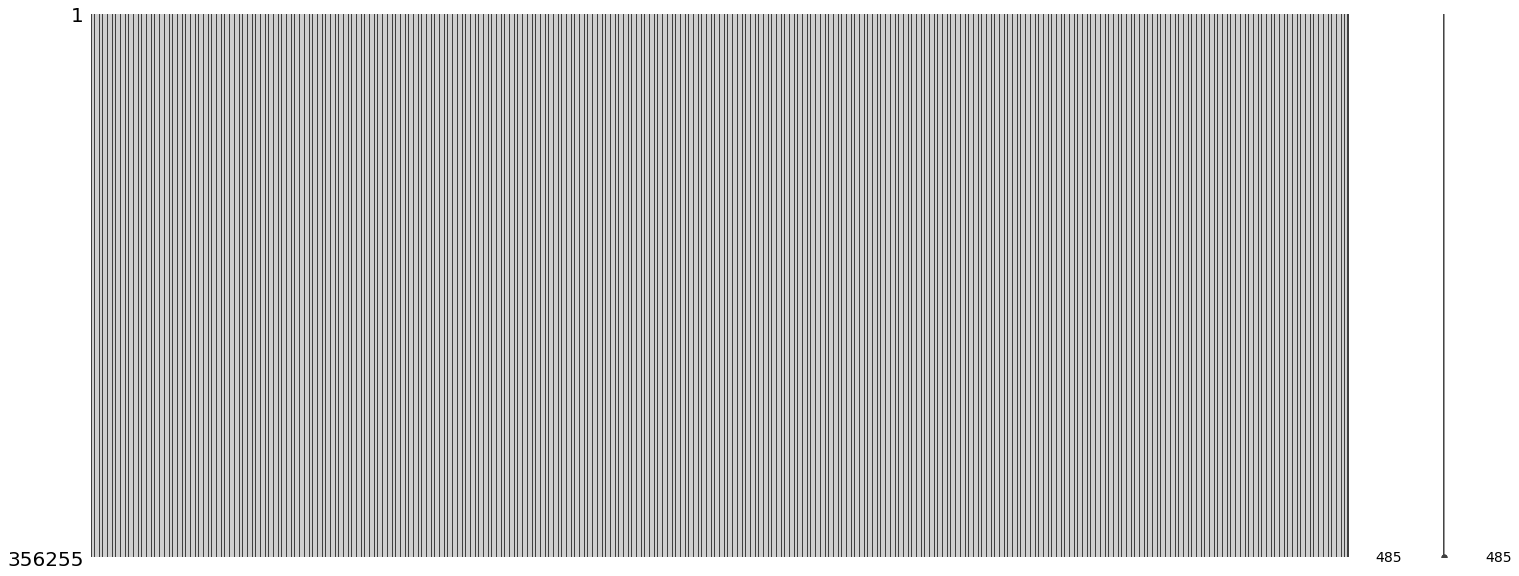

In [4]:
msno.matrix(df_final)

In [1]:
df_final.shape

NameError: name 'df_final' is not defined

In [5]:
df_final.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employ

#### We have so far preprocessed all the datasets and merged them together , we ended up with a dataframe of shape (356255, 485).
#### Next we will try to reduce the number of features and therefore improve the efficiency and effectiveness of  our predictive model.
#### To do so we will try to calculate the relative importance of each feature when making a prediction - Feature importance.


## 3) Scaling the data

In [ ]:
# # As we see above the data values differ greatly betwenn their ranges
# # The scaling removes the mean and scales the data to the unit variance 
# from sklearn.preprocessing import StandardScaler

# data = df_final.to_numpy()
# scaler = StandardScaler()

# fitted_data = scaler.fit(data)
# scaled_data = scaler.transform(data)

In [4]:
# Getting the indexes of the infinite values in the datframe 
infinity = df_final.iloc[df_final.values==np.inf] 
infinity_values_indexes = list(infinity.index.values) 

# Dropping the infinite value indexes ( the rows with infinte values)
infity_free_data = df_final.drop(infinity_values_indexes) # the X ( independent features)
infinity_indexes_free_targets = df_final['TARGET'].drop(infinity_values_indexes) # the Y ( target variable)

In [5]:
# value = (value – median) / (p75 – p25)
#Standardization can become skewed or biased if the input variable contains outlier values
# This is why we use robustscaler
from sklearn.preprocessing import RobustScaler
trans = RobustScaler()
data_scaled = trans.fit_transform(infity_free_data)

In [6]:
df_scaled = pd.DataFrame(data_scaled, columns = infity_free_data.columns)

In [9]:
df_scaled.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employ

In [165]:
# Saving the final processed data
df_scaled.to_csv('./df_scaled.csv', index=False)

In [321]:
df_scaled = pd.read_csv('./df_scaled.csv')

In [322]:
df_scaled.shape

(356235, 485)

## 4) Splitting into train and test data

In [323]:
X_scaled = df_scaled.drop(['TARGET'], axis=1).iloc[0:100000]
y_scaled =  df_scaled['TARGET'].astype(int).iloc[0:100000]

In [324]:
from sklearn.model_selection import train_test_split
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3,random_state=0)

X_train.shape, X_test.shape

((70000, 484), (30000, 484))

In [325]:
y_test.shape

(30000,)

In [326]:
y_test.to_csv('./y_test.csv', index = False)

In [5]:
y_test= pd.read_csv('./y_test.csv')

## 5) Dealing with imbalanced data


In [ ]:
# # check scikit-learn version
# print(sklearn.__version__)

In [ ]:
y_train.value_counts()

In [ ]:
# We see that we have an imbalanced data so we will have to deal with it  before training any model on the data
y_train.plot.hist()

In [ ]:
# pip install -U imbalanced-learn

In [ ]:
# pip install imblearn --user 

In [ ]:
SMOTE 

In [9]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)


<AxesSubplot:ylabel='Frequency'>

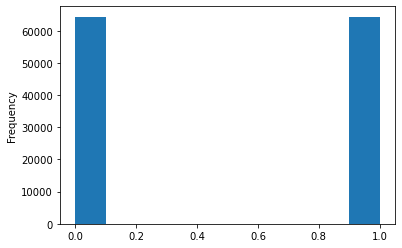

In [10]:
y_resampled.plot.hist()

In [11]:
X_resampled.shape


(128732, 484)

In [12]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_resampled)))

Original dataset shape Counter({0: 64366, 1: 5634})
Resampled dataset shape Counter({0: 64366, 1: 64366})


# II) Reducing the number of features

### We have so far a dataframe with 484 features (columns) and 128732 samples (rows)


## Feature selection - dropping constant features

In [13]:
from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold()
var_thres.fit(X_resampled)


VarianceThreshold()

In [14]:
# Lets Find non-constant features 
len(X_resampled.columns[var_thres.get_support()])

455

In [15]:
# defining the constant columns
constant_columns = [column for column in X_resampled.columns
                    if column not in X_resampled.columns[var_thres.get_support()]]

print(len(constant_columns))

29


In [16]:
constant_columns

['NAME_CONTRACT_TYPE_nan',
 'NAME_TYPE_SUITE_nan',
 'NAME_INCOME_TYPE_nan',
 'NAME_EDUCATION_TYPE_nan',
 'NAME_FAMILY_STATUS_nan',
 'NAME_HOUSING_TYPE_nan',
 'WEEKDAY_APPR_PROCESS_START_nan',
 'ORGANIZATION_TYPE_nan',
 'BURO_CREDIT_ACTIVE_nan_MEAN',
 'BURO_CREDIT_CURRENCY_nan_MEAN',
 'BURO_CREDIT_TYPE_Interbank credit_MEAN',
 'BURO_CREDIT_TYPE_nan_MEAN',
 'PREV_NAME_CONTRACT_TYPE_nan_MEAN',
 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN',
 'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN',
 'PREV_NAME_CONTRACT_STATUS_nan_MEAN',
 'PREV_NAME_PAYMENT_TYPE_nan_MEAN',
 'PREV_CODE_REJECT_REASON_nan_MEAN',
 'PREV_NAME_CLIENT_TYPE_nan_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Animals_MEAN',
 'PREV_NAME_GOODS_CATEGORY_House Construction_MEAN',
 'PREV_NAME_GOODS_CATEGORY_nan_MEAN',
 'PREV_NAME_PORTFOLIO_nan_MEAN',
 'PREV_NAME_PRODUCT_TYPE_nan_MEAN',
 'PREV_CHANNEL_TYPE_nan_MEAN',
 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN',
 'PREV_NAME_YIELD_GROUP_nan_MEAN',
 'POS_NAME_CONTRACT_

In [17]:
# Droppping the contant columns from the dataframe
X = X_resampled.drop(constant_columns,axis=1)


In [18]:
print(X.shape)

(128732, 455)


## Feature selection based on correlation

In [19]:

# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with any other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [20]:
corr_features = correlation(X, 0.7)
len(set(corr_features))

122

In [21]:
X = X.drop(corr_features,axis=1)

print(X.shape)



(128732, 333)


## Feature Selection-Information gain - mutual information In Classification Problem 
 - mutual information measures the amount of information one can obtain from one random variable given another
 - (X ; Y) = H(X) – H(X | Y) Where I(X ; Y) is the mutual information for X and Y, H(X) is the entropy for X and H(X | Y) is the conditional entropy for X given Y. The result has the units of bits.

In [22]:
#from sklearn.feature_selection import mutual_info_classif
# Calculate the mutual information
mutual_info = mutual_info_classif(X, y_resampled)

In [23]:
# Get the columns for which the dependecy to the target values is equal to 0
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
#_mutual_info_values = mutual_info.sort_values(ascending=False)

dataframe_mutual_info = pd.DataFrame(mutual_info)
zero_dependent_cols = dataframe_mutual_info.index[dataframe_mutual_info[0] == 0.000000].tolist()


In [24]:
X = X.drop(zero_dependent_cols, axis=1)

In [25]:
X.shape

(128732, 304)

 ## Feature Selection base on variance
 
 It shows how spread out the distribution is in a single metric, this is important as a low variance (near 0) means that thhe feature is useless for ML predictions.
 
 variance :
 
 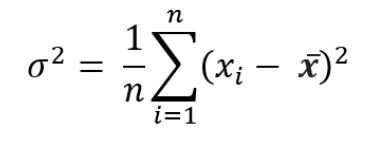

In [26]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0.005)

# Fitting the data to the estimator
cols_not_dropped = vt.fit(X)

#Returns a boolean mask with True values for columns which are not dropped (columns other than 0 variance)
mask = vt.get_support()

X = X.loc[:, mask]

In [27]:
X.shape

(128732, 188)

## Feature selection based on Variance inflation factor

In [28]:
### Feature selection based on colinearity (Variance Inflation Factor)
# Variance inflation factor (VIF) is the quotient of the variance in a model with multiple terms
# by the variance of a model with one term alone. It quantifies the severity of multicollinearity.
# Let's compute the values of VIF for our quantitative features:

#from statsmodels.stats.outliers_influence import variance_inflation_factor    

variables = X.columns
var_inflation = pd.Series([variance_inflation_factor(X.loc[:, variables].values, ix)\
               for ix in range(len(variables))], index = variables).to_frame(name='variance_inflation')
var_inflation = var_inflation.sort_values('variance_inflation')

display(var_inflation.sort_values('variance_inflation'))

,variance_inflation
INS_PAYMENT_PERC_MAX,1.007079
AMT_INCOME_TOTAL,1.014900
NAME_TYPE_SUITE_Children,1.016591
NAME_EDUCATION_TYPE_Lower secondary,1.024404
AMT_REQ_CREDIT_BUREAU_WEEK,1.036062
...,...
NAME_FAMILY_STATUS_Widow,4892.264503
NAME_FAMILY_STATUS_Separated,6642.112771
NAME_FAMILY_STATUS_Civil marriage,10730.504743
NAME_FAMILY_STATUS_Single / not married,14728.150739


In [29]:
high_var_inf_cols = var_inflation[var_inflation['variance_inflation']>5].index
high_var_inf_cols

Index(['PREV_NAME_SELLER_INDUSTRY_Consumer electronics_MEAN',
       'PREV_NAME_GOODS_CATEGORY_Computers_MEAN',
       'PREV_NAME_CONTRACT_STATUS_Canceled_MEAN',
       'NAME_HOUSING_TYPE_Rented apartment',
       'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN',
       'PREV_NAME_GOODS_CATEGORY_Consumer Electronics_MEAN',
       'PREV_NAME_YIELD_GROUP_low_action_MEAN', 'PREV_APP_CREDIT_PERC_MIN',
       'PREV_NAME_TYPE_SUITE_Family_MEAN', 'PREV_APP_CREDIT_PERC_MEAN',
       'PREV_CHANNEL_TYPE_Stone_MEAN', 'FLAG_DOCUMENT_3',
       'PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN',
       'PREV_CHANNEL_TYPE_Country-wide_MEAN',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'PREV_NAME_GOODS_CATEGORY_Mobile_MEAN',
       'PREV_NAME_YIELD_GROUP_low_normal_MEAN',
       'PREV_NAME_TYPE_SUITE_nan_MEAN',
       'PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN',
       'PREV_NAME_YIELD_GROUP_middle_MEAN', 'PREV_NAME_YIELD_GROUP_high_MEAN',
       'NAME_HOUSING_TYPE_With parents', 'NAME_HOUSING_TYPE_House /

In [30]:
X = X.drop(high_var_inf_cols, axis=1)

print(X.shape)

(128732, 138)


## Feature selection based on  Permutation importance (model based)

In [ ]:
pip install lightgbm

In [31]:
# Changing the names of some features because of error:
#LightGBMError: Do not support special JSON characters in feature name.
# The check for special json characters .e.g [],{}": in features names and throw an error if found.
#import re
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


In [32]:
# import lightgbm
# from sklearn.inspection import permutation_importance
# from sklearn.linear_model import LogisticRegression
# from lightgbm import LGBMClassifier
# from sklearn.ensemble import RandomForestClassifier

lgbm = LGBMClassifier()
lgbm.fit(X, y_resampled)
result_lgbm = permutation_importance(lgbm, X, y_resampled,
                                     n_repeats=10, random_state=14)

rf = RandomForestClassifier()
rf.fit(X, y_resampled)
result_rf = permutation_importance(rf, X, y_resampled,
                                   n_repeats=10, random_state=14)

df_permut_importance = pd.DataFrame({'LGBM': result_lgbm.importances_mean*1000,
                                   'RF': result_rf.importances_mean*1000},
                                  index=X.columns)

NameError: name 'sample_X' is not defined

In [33]:
df_permut_importance = pd.DataFrame({'LGBM': result_lgbm.importances_mean*1000,
                                   'RF': result_rf.importances_mean*1000},
                                  index=X.columns)

In [34]:
# boolean masks to select features to be dropped
# find n less important features according to both models

n=25
less_perm_imp_feat = df_permut_importance
factors = np.logspace(0,4,30)#.astype('int')
cpt = 0
while less_perm_imp_feat.shape[0]>=n:
    print(cpt, less_perm_imp_feat.shape)
    # boolean masks to select features to be dropped
    try:
        
        cond1 = df_permut_importance['LGBM']<df_permut_importance['LGBM'].std()/factors[cpt]
        cond2 = df_permut_importance['RF']<df_permut_importance['RF'].std()/factors[cpt]
        less_perm_imp_feat = df_permut_importance.loc[cond1&cond2]
        cpt += 1
    except:
        break
        
less_perm_imp_feat

0 (138, 2)
1 (128, 2)
2 (126, 2)
3 (124, 2)
4 (123, 2)
5 (121, 2)
6 (120, 2)
7 (119, 2)
8 (114, 2)
9 (111, 2)
10 (108, 2)
11 (100, 2)
12 (95, 2)
13 (84, 2)
14 (71, 2)
15 (65, 2)
16 (54, 2)
17 (42, 2)
18 (39, 2)


,LGBM,RF
AMT_REQ_CREDIT_BUREAU_HOUR,0.000000e+00,0.000000
AMT_REQ_CREDIT_BUREAU_WEEK,-1.553615e-03,0.000000
NAME_TYPE_SUITE_Spousepartner,3.107231e-03,0.000000
NAME_EDUCATION_TYPE_Incompletehigher,1.553615e-02,0.000000
NAME_EDUCATION_TYPE_Lowersecondary,-3.884038e-03,0.000000
NAME_HOUSING_TYPE_Officeapartment,3.107231e-03,0.000000
ORGANIZATION_TYPE_Agriculture,0.000000e+00,0.000000
ORGANIZATION_TYPE_Bank,2.330423e-03,0.000000
ORGANIZATION_TYPE_BusinessEntityType2,0.000000e+00,0.000000
ORGANIZATION_TYPE_Government,-8.544884e-03,0.000000


In [35]:
X.shape

(128732, 138)

In [36]:
X = X.drop(less_perm_imp_feat.index , axis =1)

In [37]:
X.shape

(128732, 114)

In [38]:
X.to_csv('./X.csv', index = False)
y_resampled.to_csv('./y_resampled.csv', index = False)

In [329]:
X_training = pd.read_csv('./X.csv')
y_training = pd.read_csv('./y_resampled.csv')


In [330]:
X_training.shape

(128732, 114)

In [17]:
# transforme y train in 1D array for ML training
y_training =  y_training.values.ravel()

In [331]:
# We had changed the columns names for the training data let's do the same to the test set 
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [332]:
# Réduce the number of features by keeping those that where chosen for training data
cols_to_keep = list(X_training.columns)

In [ ]:
cols =['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'HOUR_APPR_PROCESS_START',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_18',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'NAME_CONTRACT_TYPE_Cashloans',
 'NAME_TYPE_SUITE_Children',
 'NAME_TYPE_SUITE_Family',
 'NAME_EDUCATION_TYPE_Highereducation',
 'NAME_EDUCATION_TYPE_Incompletehigher',
 'ORGANIZATION_TYPE_BusinessEntityType1',
 'ORGANIZATION_TYPE_BusinessEntityType2',
 'ORGANIZATION_TYPE_BusinessEntityType3',
 'ORGANIZATION_TYPE_Construction',
 'ORGANIZATION_TYPE_Industrytype11',
 'ORGANIZATION_TYPE_Industrytype3',
 'ORGANIZATION_TYPE_Postal',
 'ORGANIZATION_TYPE_Restaurant',
 'ORGANIZATION_TYPE_Security',
 'ORGANIZATION_TYPE_Selfemployed',
 'ORGANIZATION_TYPE_Tradetype3',
 'ORGANIZATION_TYPE_Transporttype4',
 'ANNUITY_INCOME_PERC',
 'BURO_DAYS_CREDIT_MIN',
 'BURO_DAYS_CREDIT_MAX',
 'BURO_DAYS_CREDIT_VAR',
 'BURO_CREDIT_DAY_OVERDUE_MAX',
 'BURO_DAYS_CREDIT_ENDDATE_MIN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'BURO_DAYS_CREDIT_ENDDATE_MEAN',
 'BURO_AMT_CREDIT_SUM_MAX',
 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'BURO_AMT_CREDIT_SUM_LIMIT_MEAN',
 'BURO_DAYS_CREDIT_UPDATE_MIN',
 'BURO_MONTHS_BALANCE_SIZE_SUM',
 'BURO_CREDIT_ACTIVE_Active_MEAN',
 'BURO_CREDIT_TYPE_Consumercredit_MEAN',
 'PREV_AMT_ANNUITY_MIN',
 'PREV_AMT_ANNUITY_MAX',
 'PREV_AMT_APPLICATION_MIN',
 'PREV_APP_CREDIT_PERC_MAX',
 'PREV_AMT_DOWN_PAYMENT_MIN',
 'PREV_AMT_DOWN_PAYMENT_MAX',
 'PREV_HOUR_APPR_PROCESS_START_MIN',
 'PREV_HOUR_APPR_PROCESS_START_MAX',
 'PREV_RATE_DOWN_PAYMENT_MIN',
 'PREV_DAYS_DECISION_MIN',
 'PREV_DAYS_DECISION_MAX',
 'PREV_CNT_PAYMENT_MEAN',
 'PREV_CNT_PAYMENT_SUM',
 'PREV_NAME_CONTRACT_STATUS_Approved_MEAN',
 'PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN',
 'PREV_CODE_REJECT_REASON_LIMIT_MEAN',
 'PREV_NAME_TYPE_SUITE_Spousepartner_MEAN',
 'PREV_NAME_GOODS_CATEGORY_AudioVideo_MEAN',
 'PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN',
 'PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Furniture_MEAN',
 'PREV_NAME_GOODS_CATEGORY_PhotoCinemaEquipment_MEAN',
 'PREV_CHANNEL_TYPE_APCashloan_MEAN',
 'PREV_CHANNEL_TYPE_Contactcenter_MEAN',
 'PREV_CHANNEL_TYPE_RegionalLocal_MEAN',
 'PREV_NAME_SELLER_INDUSTRY_Industry_MEAN',
 'PREV_PRODUCT_COMBINATION_CardXSell_MEAN',
 'PREV_PRODUCT_COMBINATION_CashStreethigh_MEAN',
 'PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN',
 'PREV_PRODUCT_COMBINATION_CashXSellhigh_MEAN',
 'PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN',
 'PREV_PRODUCT_COMBINATION_CashXSellmiddle_MEAN',
 'PREV_PRODUCT_COMBINATION_POSmobilewithoutinterest_MEAN',
 'PREV_PRODUCT_COMBINATION_POSotherwithinterest_MEAN',
 'POS_SK_DPD_MAX',
 'POS_SK_DPD_DEF_MAX',
 'POS_NAME_CONTRACT_STATUS_Active_MEAN',
 'INS_NUM_INSTALMENT_VERSION_NUNIQUE',
 'INS_DPD_MAX',
 'INS_DPD_MEAN',
 'INS_DPD_SUM',
 'INS_DBD_MAX',
 'INS_DBD_MEAN',
 'INS_DBD_SUM',
 'INS_PAYMENT_PERC_MAX',
 'INS_PAYMENT_DIFF_MAX',
 'INS_PAYMENT_DIFF_MEAN',
 'INS_AMT_INSTALMENT_MEAN',
 'INS_AMT_PAYMENT_MIN',
 'INS_DAYS_ENTRY_PAYMENT_SUM']

In [333]:
# New test set with selected columns
X_testing = X_test[cols_to_keep]

In [334]:
X_testing.shape

(30000, 114)

In [335]:
X_testing.to_csv('./X_testing.csv', index = False)

In [2]:
X_testing = pd.read_csv('./X_testing.csv')

In [337]:
X_testing.shape

(30000, 114)

In [ ]:
test_data

In [8]:
mmm = X_testing.iloc[0:100]

In [10]:
mmm.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,INS_DPD_MEAN,INS_DPD_SUM,INS_DBD_MAX,INS_DBD_MEAN,INS_DBD_SUM,INS_PAYMENT_DIFF_MAX,INS_PAYMENT_DIFF_MEAN,INS_AMT_INSTALMENT_MEAN,INS_AMT_PAYMENT_MIN,INS_DAYS_ENTRY_PAYMENT_SUM
0,0.0,1.0,1.0,1.0,2.3,1.619329,0.638098,0.259275,-0.294661,0.170923,...,0.214715,0.000000,0.578947,-0.041908,-0.437333,0.000000,0.000000,0.085897,0.804242,0.111533
1,0.0,0.0,0.0,0.0,-0.2,0.891218,0.074824,-0.833678,0.411080,-0.223276,...,1.170270,0.277778,0.000000,0.388606,-0.285333,0.519759,1.064821,-0.686634,-0.255901,0.354930
2,0.0,0.0,1.0,1.0,-0.2,-0.330396,-0.422576,-0.018618,-3.105982,0.580628,...,3.930270,1.444444,-0.789474,-0.997421,-0.586667,0.000000,0.000000,-0.720062,0.216847,-0.098596
3,-1.0,1.0,0.0,0.0,0.3,-0.436371,0.908077,0.858778,-0.113609,0.088654,...,-0.029730,-0.055556,-0.789474,0.043731,-0.034667,0.000000,0.000000,0.322131,1.495367,0.297975
4,-1.0,1.0,0.0,0.0,0.8,0.757811,-0.194511,0.471107,-0.266961,0.797337,...,0.142819,0.166667,0.000000,-0.848030,-0.226667,2.598793,2.164837,0.807714,-0.251744,-0.067633


In [9]:
mmm.shape

(100, 114)

## III) Training the models and fine tuning 

## Logistic Regression 
 Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable.

In [ ]:
# Grid search cross validation, calculate the best hyperparameters for the model

logreg_model=LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ["l1","l2"] # l1 lasso l2 ridge
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
logreg_cv =RandomizedSearchCV(estimator=logreg_model, param_distributions=grid, n_jobs=-1, cv=cv,
                           scoring= 'roc_auc',error_score=0)


In [53]:
# Show the results of best parameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.782081 using {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1}


In [159]:
logreg_model=LogisticRegression(solver = 'newton-cg', penalty = 'l2', C = 0.1)

In [160]:
logreg = logreg_model.fit(X_training, y_training)

C:\Users\adele\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [60]:
# Save the model with joblib
joblib.dump(logreg_model, 'logreg_model_joblib')

['logreg_model_joblib']

In [10]:
# Load the model 
logreg = joblib.load('logreg_model_joblib')

In [476]:
logreg_y_pred = logreg.predict(X_testing)

In [20]:
# Show the results of scores
test_score = grid_result.cv_results_['mean_test_score']
fit_time = grid_result.cv_results_['mean_fit_time']
params = grid_result.cv_results_['params']
for test_score, fit_time, param in zip(test_score, fit_time, params):
    print("%f (%f) with: %r" % (test_score, fit_time, param))

NameError: name 'grid_result' is not defined

In [477]:
print(classification_report(y_test,logreg_y_pred ))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     27542
           1       0.17      0.66      0.27      2458

    accuracy                           0.70     30000
   macro avg       0.56      0.68      0.54     30000
weighted avg       0.89      0.70      0.77     30000



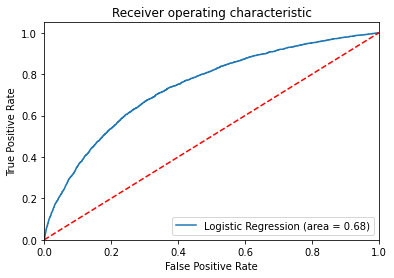

In [478]:
# Plot the AUC_ROC curve
logit_roc_auc_lr = roc_auc_score(y_test, logreg.predict(X_testing))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_testing)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_lr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [517]:

# Plot the confusion matrix
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

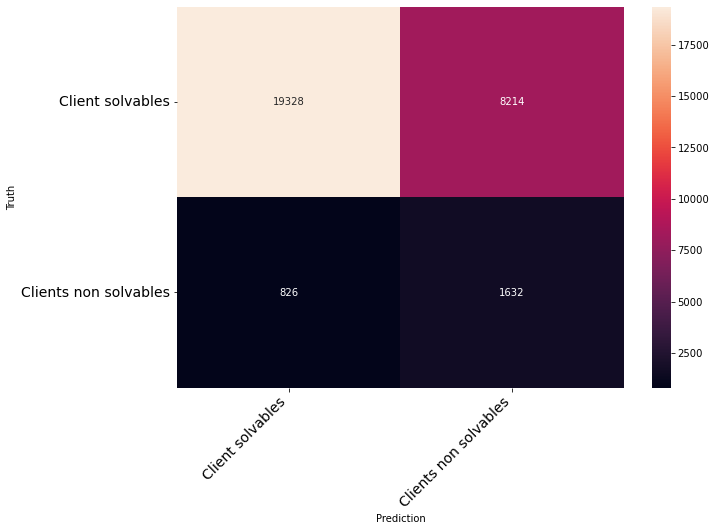

In [63]:
cm = confusion_matrix(y_test,logreg_y_pred)
print_confusion_matrix(cm,["Client solvables","Clients non solvables"])

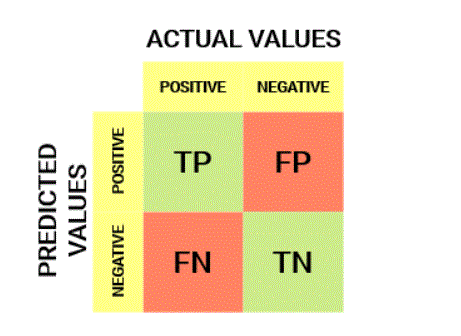


In [64]:
print(classification_report(y_test,logreg_y_pred ))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     27542
           1       0.17      0.66      0.27      2458

    accuracy                           0.70     30000
   macro avg       0.56      0.68      0.54     30000
weighted avg       0.89      0.70      0.77     30000



In our study Class 0 are the good clients = negative class
and class 1 are the bad clients = positive classe


    --> Accuracy= (TP+TN)/(TP+TN+FP+FN)  # this is the % of right predictions( in class 0 and 1)

    --> Recall = TP/(TP+FN)  # out of all good clients how many we've got predicted correctly as 
        class 0 ( TP are good clients that are predicted good but FN are also good clients but that are predicted bad falsly)

    --> Precision = TP/(TP+FP)  # the ratio of good clients out of all good clients that were predicted to be so and the bad clients that were predicted to be good falsely


## Now for our case we are interested in reducing the FN values (clients that have been predicted as bad clients but are good clients in reality)

    We will calcultate the F scores
    Fbeta = (1+beta²) precision*Recall/ (beta²* Precision+Recall)

    For reducing FP beta should be less than 1
    For reducing FN beta suld be greater than 1
    In case of balanced data ( reducing FN and FP) beta should be = 1


In [65]:
# Calculating the F beta scores
y_true = y_test
y_pred = logreg_y_pred
fbeta_score(y_true, y_pred, average='macro', beta=1)

fbeta_score(y_true, y_pred, average='micro', beta=1)


0.6986666666666667

## Global interpretability of Logistic regression model


 ## XGBoost model 
 
 A gradient tree boosting-based method with some extensions.
 One of the extensions is the sparsity awareness that can handle the possibility of missing values.
 Therefore, XGBoost can process data with missing values without doing imputation first.

In [ ]:

# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score
# Grid search cross validation
XGBoost_model = XGBClassifier(use_label_encoder=False)

grid =params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
XGBoost_cv =RandomizedSearchCV(estimator=XGBoost_model, param_distributions=grid, n_jobs=-1, cv=cv,
                           scoring= 'roc_auc',error_score=0)

XGB_results = XGBoost_cv.fit(X_training, y_training)

In [68]:
print("Best: %f using %s" % (XGB_results.best_score_, XGB_results.best_params_))

Best: 0.978962 using {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 1.5, 'colsample_bytree': 0.8}


In [21]:
xgb = XGBClassifier(subsample= 1, min_child_weight= 5, max_depth =4, gamma= 1.5, colsample_bytree= 0.8)

In [22]:
xgb_model = xgb.fit(X_training, y_training)

In [23]:
# Saving the model
joblib.dump(xgb_model, 'xgb_model_joblib')

['xgb_model_joblib']

In [18]:
# Load the model 
xgb_model = joblib.load('xgb_model_joblib')

In [19]:
xgb_y_pred =xgb_model.predict(X_testing)

In [125]:
type(xgb_y_pred)

numpy.ndarray

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, xgb_y_pred)
print(confusion_matrix)

[[27407   135]
 [ 2359    99]]


In [73]:
XGB_results.cv_results_

{'mean_fit_time': array([147.28032535, 230.77039853, 215.94507765, 233.35755897,
        132.93517674, 158.55650468, 356.61717486, 348.56863942,
        228.39782186, 123.00064054]),
 'std_fit_time': array([7.82714603, 2.27808852, 2.54691314, 1.47177426, 2.37437894,
        4.70212354, 2.78473199, 3.64257897, 2.205072  , 8.88615579]),
 'mean_score_time': array([0.21993806, 0.25500667, 0.23378894, 0.26882303, 0.24360148,
        0.25803896, 0.27901392, 0.27132903, 0.25290501, 0.2239861 ]),
 'std_score_time': array([0.02114363, 0.01182965, 0.01261686, 0.01284015, 0.01119213,
        0.01660706, 0.01659282, 0.01358871, 0.01448032, 0.04048416]),
 'param_subsample': masked_array(data=[0.8, 1.0, 1.0, 1.0, 0.8, 0.6, 1.0, 1.0, 1.0, 0.8],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[1, 5, 5, 5, 5, 10, 5, 10, 1, 10],
              mas

In [74]:

xgb_test_score = XGB_results.cv_results_['mean_test_score']
xgb_fit_time = XGB_results.cv_results_['mean_fit_time']
xgb_params = XGB_results.cv_results_['params']
for test_score, fit_time, param in zip(xgb_test_score, xgb_fit_time, xgb_params):
    print ("xgb_test_score is {}, xgb_fit_time is {}, xgb_params are {} ".format(test_score, fit_time, param))   


xgb_test_score is 0.9788534981734035, xgb_fit_time is 147.28032534917196, xgb_params are {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 1.5, 'colsample_bytree': 0.6} 
xgb_test_score is 0.9789262491940567, xgb_fit_time is 230.77039852937062, xgb_params are {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 1, 'colsample_bytree': 0.8} 
xgb_test_score is 0.9786251111733795, xgb_fit_time is 215.9450776497523, xgb_params are {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 3, 'gamma': 2, 'colsample_bytree': 1.0} 
xgb_test_score is 0.9789623524013626, xgb_fit_time is 233.35755896568298, xgb_params are {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 4, 'gamma': 1.5, 'colsample_bytree': 0.8} 
xgb_test_score is 0.9785624282490252, xgb_fit_time is 132.93517673810322, xgb_params are {'subsample': 0.8, 'min_child_weight': 5, 'max_depth': 3, 'gamma': 2, 'colsample_bytree': 0.6} 
xgb_test_score is 0.9785591911022135, xgb_fit_time is 158.55650467872618

In [75]:
xgb_test_score

array([0.9788535 , 0.97892625, 0.97862511, 0.97896235, 0.97856243,
       0.97855919, 0.97886617, 0.9789486 , 0.97882326, 0.97864616])

In [76]:
xgb_fit_time

array([147.28032535, 230.77039853, 215.94507765, 233.35755897,
       132.93517674, 158.55650468, 356.61717486, 348.56863942,
       228.39782186, 123.00064054])

In [77]:
xgb_params

[{'subsample': 0.8,
  'min_child_weight': 1,
  'max_depth': 4,
  'gamma': 1.5,
  'colsample_bytree': 0.6},
 {'subsample': 1.0,
  'min_child_weight': 5,
  'max_depth': 4,
  'gamma': 1,
  'colsample_bytree': 0.8},
 {'subsample': 1.0,
  'min_child_weight': 5,
  'max_depth': 3,
  'gamma': 2,
  'colsample_bytree': 1.0},
 {'subsample': 1.0,
  'min_child_weight': 5,
  'max_depth': 4,
  'gamma': 1.5,
  'colsample_bytree': 0.8},
 {'subsample': 0.8,
  'min_child_weight': 5,
  'max_depth': 3,
  'gamma': 2,
  'colsample_bytree': 0.6},
 {'subsample': 0.6,
  'min_child_weight': 10,
  'max_depth': 4,
  'gamma': 1.5,
  'colsample_bytree': 0.6},
 {'subsample': 1.0,
  'min_child_weight': 5,
  'max_depth': 5,
  'gamma': 2,
  'colsample_bytree': 1.0},
 {'subsample': 1.0,
  'min_child_weight': 10,
  'max_depth': 5,
  'gamma': 1.5,
  'colsample_bytree': 1.0},
 {'subsample': 1.0,
  'min_child_weight': 1,
  'max_depth': 4,
  'gamma': 1.5,
  'colsample_bytree': 0.8},
 {'subsample': 0.8,
  'min_child_weight': 1

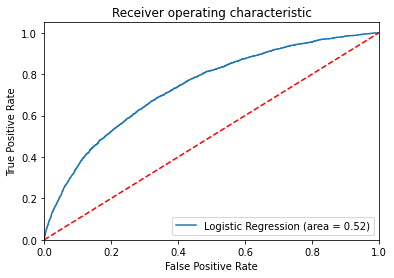

In [21]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc_xgb = roc_auc_score(y_test, xgb_model.predict(X_testing))
fpr, tpr, thresholds = roc_curve(y_test, xgb_model.predict_proba(X_testing)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % logit_roc_auc_xgb)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

A confusion matrix shows the combination of the actual and predicted classes. Each row of the matrix represents the instances in a predicted class, while each column represents the instances in an actual class. 

### Random Forest model

In [80]:

# from sklearn.ensemble import RandomForestClassifier
# Number of trees in random forest
n_estimators = [100, 500, 1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [50, 100, 115]
scoring = ['roc_auc']
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# Criterion
criterion=['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               
               #'bootstrap': bootstrap,
               'criterion': criterion}

In [81]:

rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               random_state=42)


In [85]:
random_forest_model =rf_random.fit(X_training, y_training)

C:\Users\adele\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\adele\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\adele\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\adele\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y wa

In [92]:
# Saving the model
joblib.dump(random_forest_model, 'random_forest_model_joblib')

['random_forest_model_joblib']

In [22]:
# Load the model 
random_forest_model_joblib = joblib.load('random_forest_model_joblib')

In [86]:
print("Best: %f using %s" % (random_forest_model.best_score_, random_forest_model.best_params_))

Best: 0.956096 using {'n_estimators': 1000, 'max_features': 'auto', 'max_depth': 100, 'criterion': 'gini'}


In [87]:
random_forest = RandomForestClassifier( n_estimators =1000, max_features = 'auto',max_depth = 100, criterion = 'gini')

In [96]:

rf_test_score = random_forest_model.cv_results_['mean_test_score']
rf_fit_time = random_forest_model.cv_results_['mean_fit_time']
rf_params = random_forest_model.cv_results_['params']
for test_score, fit_time, param in zip(rf_test_score, rf_fit_time, rf_params):
     print ("rf_test_score is {}, rf_fit_time is {}, rf_params are {} ".format(test_score, fit_time, param))

rf_test_score is 0.9559793192957695, rf_fit_time is 548.7664857387542, rf_params are {'n_estimators': 1000, 'max_features': 'sqrt', 'max_depth': 115, 'criterion': 'entropy'} 
rf_test_score is 0.9560026205679343, rf_fit_time is 213.75383791923522, rf_params are {'n_estimators': 500, 'max_features': 'auto', 'max_depth': 115, 'criterion': 'gini'} 
rf_test_score is 0.9559094085398835, rf_fit_time is 560.4659914970398, rf_params are {'n_estimators': 1000, 'max_features': 'auto', 'max_depth': 100, 'criterion': 'entropy'} 
rf_test_score is 0.9556918957050022, rf_fit_time is 56.762437677383424, rf_params are {'n_estimators': 100, 'max_features': 'auto', 'max_depth': 115, 'criterion': 'entropy'} 
rf_test_score is 0.9559560113859253, rf_fit_time is 211.8937048435211, rf_params are {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 115, 'criterion': 'gini'} 
rf_test_score is 0.9559404777073368, rf_fit_time is 281.7353369235992, rf_params are {'n_estimators': 500, 'max_features': 'auto', '

In [23]:
y_preds_random_forest_= random_forest_model_joblib.predict(X_testing)

In [ ]:
#metrics.confusion_matrix(y_test, preds)

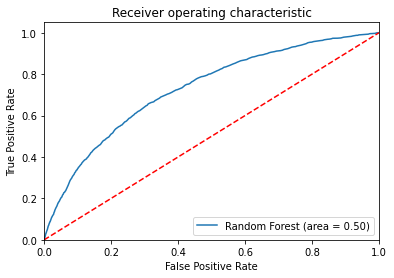

In [24]:
logit_roc_auc_rf = roc_auc_score(y_test, random_forest_model_joblib.predict(X_testing))
fpr, tpr, thresholds = roc_curve(y_test, random_forest_model_joblib.predict_proba(X_testing)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc_rf)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

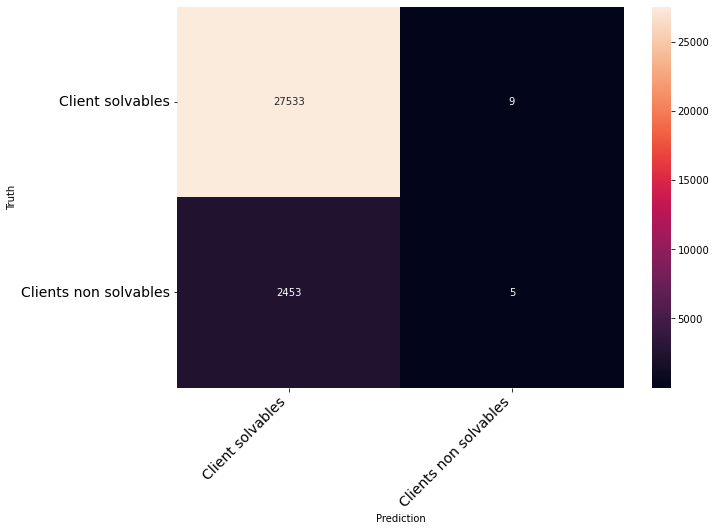

In [33]:
cm_rf = confusion_matrix(y_test,y_preds_random_forest_)
print_confusion_matrix(cm_rf,["Client solvables","Clients non solvables"])

In [101]:
type(y_preds_random_forest_)

numpy.ndarray

The random forest model was trained on google collab, we have dowloaded the AUC scores for compararison.
This model performances are poor even after hyperpameter tuning. 

## SVC model

In [27]:
from sklearn.svm import SVC
model = SVC()

In [98]:
svc_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

In [99]:
from sklearn.model_selection import RandomizedSearchCV
grid = RandomizedSearchCV(model, svc_grid, refit = True, verbose = 3)

In [ ]:
# fitting the model for grid search
grid.fit(X_training, y_training)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\adele\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .........C=1, gamma=1, kernel=rbf;, score=0.818 total time=137.6min


C:\Users\adele\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .........C=1, gamma=1, kernel=rbf;, score=0.783 total time=178.7min


C:\Users\adele\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .........C=1, gamma=1, kernel=rbf;, score=0.777 total time=218.3min


C:\Users\adele\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


 #### C parameter deals with outliers:
An SVM will find the line or hyperplane that splits the data with the largest margin possible.
Though there will be outliers that sway the line in a certain direction, a C value that is small enough will enforce regularization throughout.

#### kernel : 
Polynomial features tend to be computationally expensive, and may increase runtime with large datasets. Instead of adding more polynomial features, it's better to add landmarks to test the proximity of other datapoints against.  Each member of the training set can be considered a landmark, and a kernel is the similarity function that measures how close an input is to said landmarks.



In [37]:
model = SVC(C = 1, gamma = 1, kernel='rbf', probability=True)

In [475]:
model_svc_test = model.fit(X_res, y_res)

In [479]:
svc_y_pred_test = model_svc_test.predict(X_testing)

In [488]:
# Saving svc model
joblib.dump(model_svc_test, 'model_svc_joblib')

['model_svc_joblib']

In [ ]:
# Saving svc model
joblib.dump(model_svc, 'model_svc_joblib')

In [25]:
#load svc model
model_svc = joblib.load('model_svc_joblib')

In [481]:
logit_roc_auc_svc = roc_auc_score(y_test, model_svc_test.predict(X_testing))
fpr, tpr, thresholds = roc_curve(y_test, model_svc_test.predict_proba(X_testing)[:,1])

AttributeError: predict_proba is not available when  probability=False

In [483]:
model_svc_test.probability = True

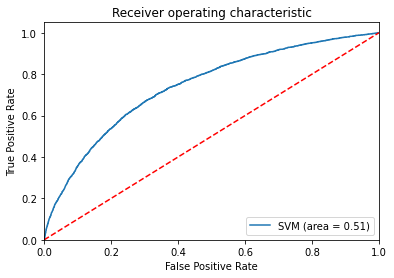

In [487]:
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % logit_roc_auc_svc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('SVM_ROC')
plt.show()

In [38]:
# X_test_prev_model= pd.read_csv('./X_test_prev_model.csv')
# y_test_prev_model= pd.read_csv('./y_test_prev_model.csv')
#cols_prev_model =X_test_prev_model.columns

In [480]:
print(classification_report(y_test,svc_y_pred_test ))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     27542
           1       0.10      0.08      0.09      2458

    accuracy                           0.87     30000
   macro avg       0.51      0.51      0.51     30000
weighted avg       0.85      0.87      0.86     30000



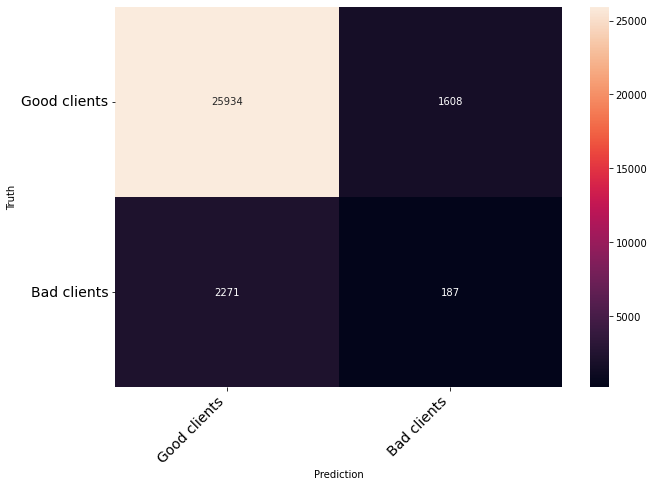

In [525]:
confusion_matrix_svc = confusion_matrix(y_test, svc_y_pred_test)
print_confusion_matrix(confusion_matrix_svc,["Good clients","Bad clients"])

## LightGBM Model

### Data preprocessing for LightGBM steps:
- Shuffle scaled data 
- Select n number of samples 
- Separate the Target variable from training data
- Split the data in train and test (shuffle data while spliting)
- Features selection on train data ( see section II)  
- Apply SMOTE to unbalanced train data (leave test data) 

In [ ]:
shuffled = df_scaled.sample(frac=1, random_state=1).reset_index()
X_scaled = shuffled.drop(['TARGET'], axis=1).iloc[0:100000]
y_scaled =  shuffled['TARGET'].astype(int).iloc[0:100000]

In [ ]:
from sklearn.model_selection import train_test_split
# separate dataset into train and test
X_tr, X_test, y_tr, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3,random_state=0, shuffle=True)

In [190]:
X_tr.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cashloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_EDUCATION_TYPE_Highereducation,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Industrytype3,ORGANIZATION_TYPE_Industrytype9,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Tradetype3,ANNUITY_INCOME_PERC,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_VAR,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_CNT_CREDIT_PROLONG_SUM,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_DAYS_CREDIT_UPDATE_MIN,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_APPLICATION_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_RATE_DOWN_PAYMENT_MIN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_NAME_TYPE_SUITE_Children_MEAN,PREV_NAME_TYPE_SUITE_Spousepartner_MEAN,PREV_NAME_GOODS_CATEGORY_AudioVideo_MEAN,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_CATEGORY_PhotoCinemaEquipment_MEAN,PREV_CHANNEL_TYPE_APCashloan_MEAN,PREV_CHANNEL_TYPE_Contactcenter_MEAN,PREV_CHANNEL_TYPE_RegionalLocal_MEAN,PREV_NAME_SELLER_INDUSTRY_Industry_MEAN,PREV_PRODUCT_COMBINATION_CardXSell_MEAN,PREV_PRODUCT_COMBINATION_CashStreethigh_MEAN,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_PRODUCT_COMBINATION_CashXSellhigh_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,PREV_PRODUCT_COMBINATION_CashXSellmiddle_MEAN,PREV_PRODUCT_COMBINATION_POSotherwithinterest_MEAN,POS_SK_DPD_MAX,POS_SK_DPD_DEF_MAX,POS_NAME_CONTRACT_STATUS_Active_MEAN,INS_NUM_INSTALMENT_VERSION_NUNIQUE,INS_DPD_MAX,INS_DPD_MEAN,INS_DPD_SUM,INS_DBD_MAX,INS_DBD_MEAN,INS_DBD_SUM,INS_PAYMENT_DIFF_MAX,INS_PAYMENT_DIFF_MEAN,INS_AMT_INSTALMENT_MEAN,INS_AMT_PAYMENT_MIN,INS_DAYS_ENTRY_PAYMENT_SUM
0,0.0,0.0,0.0,0.0,2.80,1.200887,2.876025,-0.273066,-0.818547,-1.303356,0.755094,1.0,1.0,1.0,-1.0,0.00,0.0,0.0,0.0,0.0,0.179703,-0.196705,0.0,0.0,-0.530628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.709166,-0.056911,0.279379,0.444655,0.0,0.026286,0.038692,0.022266,0.0,1.600000,0.0,0.0000,-0.415493,5.880000,0.000000,-0.740606,-0.537499,0.085045,0.869061,0.699633,0.000000,0.696535,0.000000,0.75,0.00000,-0.029772,0.242697,-0.126984,0.677419,-0.400000,0.145455,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.100000,0.0,0.0,0.0,0.0,0.000000,0.100000,0.000000,0.1,0.0,0.0,-0.545310,1.0,0.375,0.14627,0.166667,0.421053,-0.055319,0.605333,0.0,0.0,-0.155211,-0.248539,-0.073055
1,-1.0,1.0,0.0,0.0,-0.95,-0.766307,-0.617463,-0.444904,-0.706544,-1.046516,0.324491,1.0,1.0,0.0,0.0,-0.50,0.0,0.0,0.0,0.0,0.384460,0.598764,2.0,0.0,-0.477029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
# the_cols = X_training.columns
# import re
# X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# X_tr = X_train[the_cols]
# y_tr=y_train


In [378]:
y_tr.to_csv('./y_tr.csv')

In [379]:
X_tr.to_csv('./X_tr.csv')

In [2]:
X_tr= pd.read_csv('./X_tr.csv')

In [3]:
y_tr = pd.read_csv('./y_tr.csv')

In [ ]:
 X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [314]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=49)
X_res, y_res = sm.fit_resample(X_tr, y_tr)

In [36]:
X_res.to_csv('./X_res.csv', index = False )
y_res.to_csv('./y_res.csv')

In [37]:
X_res= pd.read_csv('./X_res.csv')
y_res = pd.read_csv('./y_res.csv')

In [ ]:
## Search for best hyperparameters for LGBM model

In [ ]:
pip3 install lightgbm


In [64]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

In [498]:
param_grid_lgbm = {
    'learning_rate':[ 0.01, 0.7],
    'num_leaves': [31, 300],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }

model_lgbm = lgb.LGBMClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

In [67]:
param_grid_lgbm = {
    'learning_rate':[ 0.01, 0.7],
    'num_leaves': [31, 300],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }

model_lgbm = lgb.LGBMClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)


In [77]:
lgbm_grid = GridSearchCV(model_lgbm, param_grid_lgbm, cv = cv , refit = True, verbose = 3)

In [191]:
# fit the model on the whole dataset
model_lightgbm = lgbm_grid.fit(X_res, y_res)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 1/5] END lambda_l1=0, lambda_l2=0, learning_rate=0.01, min_data_in_leaf=30, num_leaves=31, reg_alpha=0.1;, score=0.919 total time=   1.2s
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[CV 2/5] END lambda_l1=0, lambda_l2=0, learning_rate=0.01, min_data_in_leaf=30, num_leaves=31, reg_alpha=0.1;, score=0.919 total time=   1.1s
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[CV 3/5] E

In [192]:
print("Best: %f using %s" % (model_lightgbm.best_score_, model_lightgbm.best_params_))

Best: 0.919486 using {'lambda_l1': 0, 'lambda_l2': 0, 'learning_rate': 0.01, 'min_data_in_leaf': 30, 'num_leaves': 31, 'reg_alpha': 0.1}


In [499]:
best_params_lgbm =lgb.LGBMClassifier( lambda_l1 = 0, lambda_l2 = 0, learning_rate = 0.63, min_data_in_leaf = 30, num_leaves = 31, reg_alpha = 0.1, is_unbalance = True )

In [500]:
model_lightgbm = best_params_lgbm.fit(X_res, y_res)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0


In [7]:
model_lightgbm_preds = model_lightgbm.predict(X_testing)

In [503]:
# Saving the model
joblib.dump(model_lightgbm, 'model_lightgbm')

['model_lightgbm']

In [6]:
model_lightgbm = joblib.load('model_lightgbm')

In [4]:
model_lightgbm

LGBMClassifier(is_unbalance=True, lambda_l1=0, lambda_l2=0, learning_rate=0.63,
               min_data_in_leaf=30, reg_alpha=0.1)

In [504]:
logit_roc_auc_lgbm = roc_auc_score(y_test, model_lightgbm.predict(X_testing))
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_test, model_lightgbm.predict_proba(X_testing)[:,1])

In [694]:
X_testing.shape

(30000, 114)

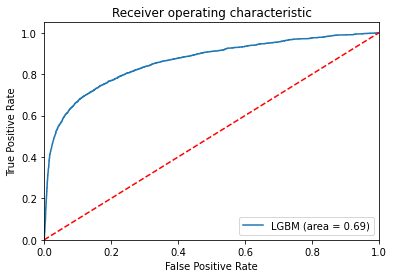

In [505]:
plt.figure()
plt.plot(fpr_lgbm, tpr_lgbm, label='LGBM (area = %0.2f)' % logit_roc_auc_lgbm)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Comparing the trained models performances 

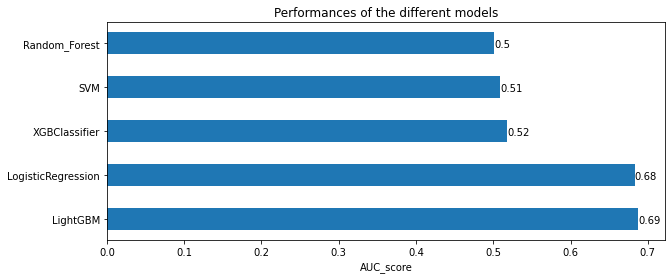

In [486]:
names = ["LogisticRegression", "XGBClassifier", "SVM", "Random_Forest", "LightGBM"]
values = [logit_roc_auc_lr, logit_roc_auc_xgb, logit_roc_auc_svc, logit_roc_auc_rf,logit_roc_auc_lgbm ]

indices = np.argsort(values)[::-1]

x = []
y = []
for i in indices:
    x.append(values[i])
    y.append(names[i])

fig, ax = plt.subplots(figsize=(10, 4))    
width = 0.50 # the width of the bars 
ind = np.arange(len(x))  # the x locations for the groups
ax.barh(ind, x, width)
ax.set_yticks(ind)
ax.set_yticklabels(y, minor=False)
plt.title('Performances of the different models')
plt.xlabel("AUC_score")
for i, v in enumerate(x):
    ax.text(v, i-.1, str(round(v,2)))

plt.show()

## ROC_AUC curves for trained models

Text(0, 0.5, 'True Positive Rate')

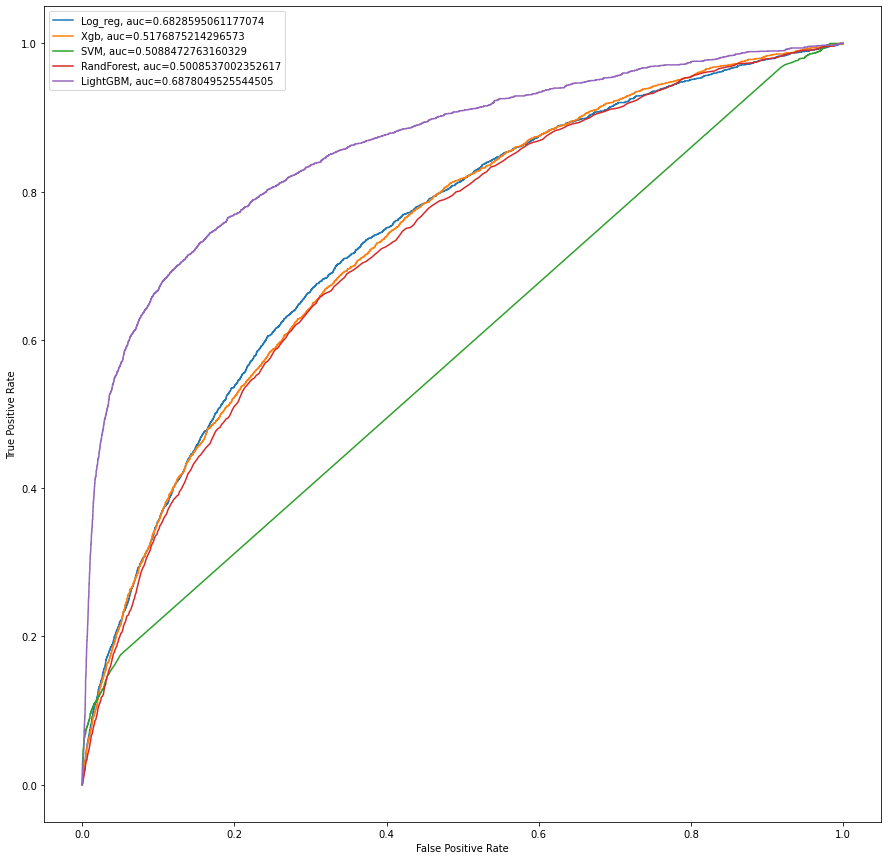

In [494]:
plt.figure(figsize= (15,15)).clf()

# ROC curve of the logistic regression model
fpr, tpr, thresh = roc_curve(y_test, logreg.predict_proba(X_testing)[:,1])

plt.plot(fpr,tpr,label="Log_reg, auc="+str(logit_roc_auc_lr))

# ROC curve of the XGBoost model
fpr, tpr, thresh = roc_curve(y_test, xgb_model.predict_proba(X_testing)[:,1])

plt.plot(fpr,tpr,label="Xgb, auc="+str(logit_roc_auc_xgb))

# ROC curve of the SVM model 
fpr, tpr, thresh = roc_curve(y_test, model_svc.predict_proba(X_tessting)[:,1])

plt.plot(fpr,tpr,label="SVM, auc="+str(logit_roc_auc_svc))

# ROC AUC curve of RandomForest model

fpr, tpr, thresholds = roc_curve(y_test, random_forest_model_joblib.predict_proba(X_testing)[:,1])

plt.plot(fpr,tpr,label="RandForest, auc="+str(logit_roc_auc_rf))

# ROC AUC curve for LightGBM model
fpr, tpr, thresholds = roc_curve(y_test, model_lightgbm.predict_proba(X_testing)[:,1])

plt.plot(fpr,tpr,label="LightGBM, auc="+str(logit_roc_auc_lgbm))

plt.legend(loc=0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Evaluate the performance of the choisen LGBM model 

## Confusion matrix

In [513]:
model_lightgbm_preds_list = list(model_lightgbm_preds)
y_test_list = list(y_test)

In [519]:
from sklearn.metrics import confusion_matrix
conf_matrix_lgbm = confusion_matrix(y_test_list,model_lightgbm_preds_list)

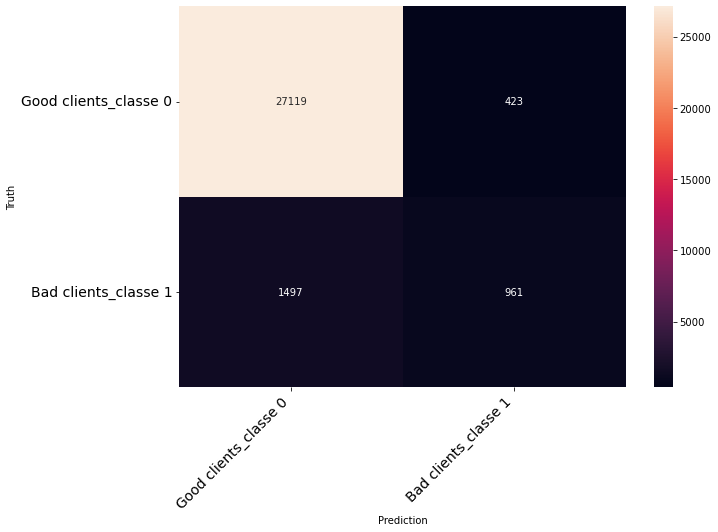

In [557]:
print_confusion_matrix(conf_matrix_lgbm,["Good clients_classe 0","Bad clients_classe 1"])

In [142]:
print(classification_report(y_test,model_lightgbm_preds ))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     27542
           1       0.69      0.39      0.50      2458

    accuracy                           0.94     30000
   macro avg       0.82      0.69      0.73     30000
weighted avg       0.93      0.94      0.93     30000



## The model seems to perfom poorly for the minority classe (class 1) 
### the precision for classe 1 is of 69 % and which means out of all predicted defaulters  69% only are really true defaulters (we have excluded 31% of potential good clients)
### the recall is even lower, 39% which means that out of all true defaulters only 39% have been revealded by the model( this is even more costly for the bank as they could give loan to defaulter clients)

### In the next part, we will try to tune the model to enhance it's predictibility scores

## F beta scores calculation

In [153]:
# Calculating the F beta scores
y_true = y_test
y_pred = model_lightgbm_preds
# fbeta_score(y_true, y_pred, average='macro', beta=1)

# fbeta_score(y_true, y_pred, average='micro', beta=1)
f_scores =[]
lis_of_betas=[]
for i in np.linspace(0, 1, num=1000):
    
        f_score = fbeta_score(y_true, y_pred, beta=i)
        f_scores.append(f_score)
        lis_of_betas.append(i)


<Figure size 432x288 with 0 Axes>

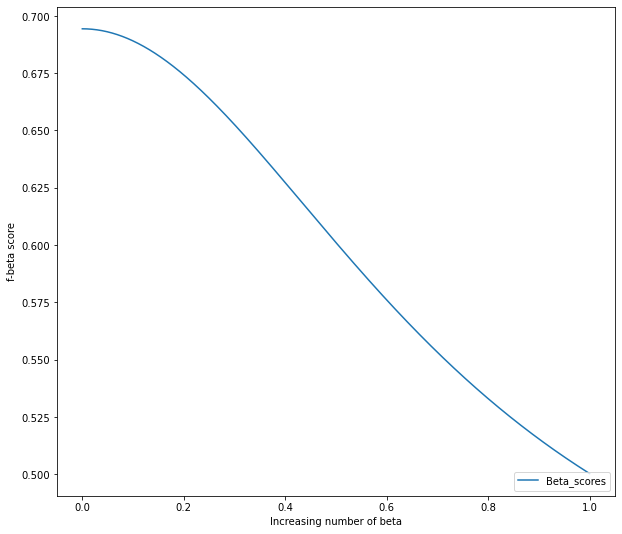

In [155]:
fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,9))
ax.plot(lis_of_betas,f_scores, label='Beta_scores')
ax.set_xlabel('Increasing number of beta')
ax.set_ylabel('f-beta score')
ax.legend(loc='lower right');

### F beta scores tend to be optimal for beta<0.3 for LGBM model

##  F beta score for an increasing threshold of predcitions probabilities

## Optimal Threshold for Precission-Recall Curve


In [317]:
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score
# Containers for f-beta, precision, and recall scores at different probability thresholds
f3_scores = []
f2_scores = []
precision_scores = []
recall_scores = []

# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0, 1, num=100)
y_test_probs = LGBM_y_pred_probas

# Find scores for each threshold
for p in probability_thresholds:
    
    y_test_preds = []

    for prob in y_test_probs:
        if prob < p:
            y_test_preds.append(0)
        else:
            y_test_preds.append(1)
            
    
    f2 = fbeta_score(y_test, y_test_preds, beta=0.5)
    f3 = fbeta_score(y_test, y_test_preds, beta=0.1)
    prec = precision_score(y_test, y_test_preds)
    rec = recall_score(y_test, y_test_preds)
  
    f2_scores.append(f2)
    f3_scores.append(f3)
   
    precision_scores.append(prec)
    recall_scores.append(rec)
    


C:\Users\adele\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [171]:
ix_lgbm = argmax(f3_scores)
print('Best Threshold=%f, F-Score=%.3f' % (probability_thresholds[ix_lgbm], f3_scores[ix_lgbm]))

Best Threshold=0.747475, F-Score=0.717


<Figure size 432x288 with 0 Axes>

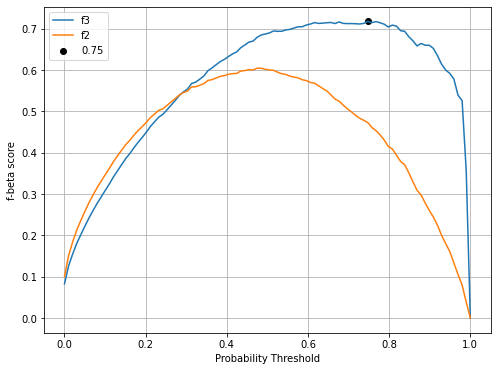

In [318]:
# Plot f_beta, precision, recall curves
# The index of the higest value of f3 scores
ix = argmax(f3_scores)
import matplotlib.pyplot as plt
fig = plt.figure()
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(probability_thresholds, f3_scores, label='f3')
ax.plot(probability_thresholds, f2_scores, 
        label='f2')
pyplot.grid(True)
#ax.plot(probability_thresholds, precision_scores, label='Precision')
#ax.plot(probability_thresholds, recall_scores, label='Recall')
plt.scatter(probability_thresholds[ix], f3_scores[ix], marker='o', color='black', label=round(probability_thresholds[ix], ndigits= 2))
ax.set_xlabel('Probability Threshold')
ax.set_ylabel('f-beta score')
ax.legend(loc='upper left');

<Figure size 432x288 with 0 Axes>

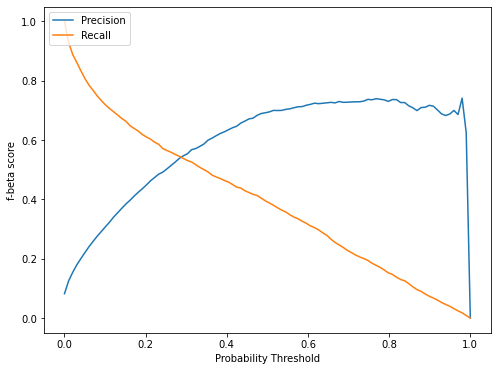

In [173]:
# Plot f_beta, precision, recall curves
# The index of the higest value of f3 scores
ix = argmax(f3_scores)
import matplotlib.pyplot as plt
fig = plt.figure()
fig, ax = plt.subplots(figsize=(8,6))
#ax.plot(probability_thresholds, f3_scores, label='f3')
#ax.plot(probability_thresholds, f2_scores, label='f2')
ax.plot(probability_thresholds, precision_scores, label='Precision')
ax.plot(probability_thresholds, recall_scores, label='Recall')
#plt.scatter(probability_thresholds[ix], f3_scores[ix], marker='o', color='black', label=round(probability_thresholds[ix], ndigits= 2))
ax.set_xlabel('Probability Threshold')
ax.set_ylabel('f-beta score')
ax.legend(loc='upper left');

## How to interpret these results: If the predicted probability is greater than 0.75 the instance is classified as class 1 ( so a defaulter) and vis versa. 
    The f beta score for a value of beta 0.1 is the best, f3=score =  0.706 for a threshold of probability 
    Low beta values ( lower than 0.5) 
    F0.5-Measure (beta=<0.5): More weight on precision (TP/TP+FP) , less weight on recall (TP/TP+FN). 
    In our case the most importance is given to cleints that would be predicted as solvent but are defaulter, because these clients would be costly for a bank. For this reason we chose a low value of beta for calculating f score.
    F1-Measure (beta=1.0): Balance the weight on precision and recall.
    F2-Measure (beta=2.0): Less weight on precision, more weight on recall


Best Threshold=0.748602, F-Score=0.720


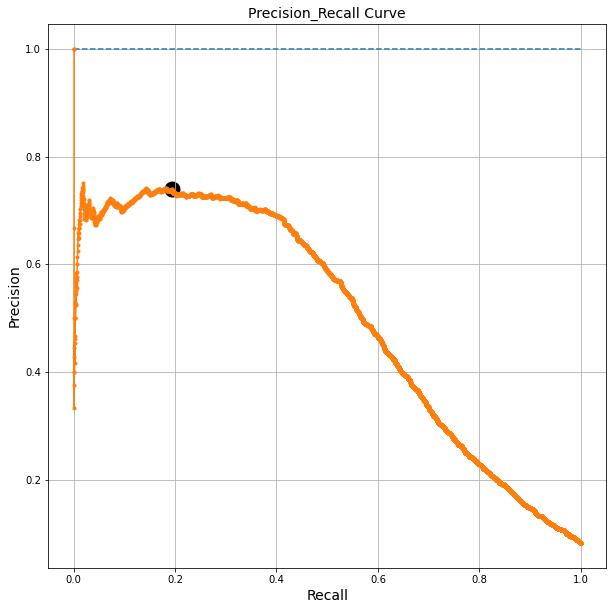

In [201]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
# Predict probabilities
yhat = model_lightgbm.predict_proba(X_testing)[:,1]

# calculate pr-curve
precision_lgbm, recall_lgbm, threshold_lgbm = precision_recall_curve(y_test, yhat)

# Calculate f-scores (beta= 0.1)fscore_lgbm = (1+beta^2 precision_lgbm * recall_lgbm) / (beta^2*precision_lgbm + recall_lgbm)
fscore_lgbm = (1.01* precision_lgbm * recall_lgbm) / (0.01*precision_lgbm + recall_lgbm)

# locate the index of the largest f score
ix = argmax(fscore_lgbm)
print('Best Threshold=%f, F-Score=%.3f' % (threshold_lgbm[ix], fscore_lgbm[ix]))


pyplot.figure(figsize= (10,10)).clf() 
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.scatter(recall_lgbm[ix], precision_lgbm[ix], marker='o', color='black', label='Best', alpha =1, linewidths =10)
pyplot.plot(recall_lgbm, precision_lgbm, marker='.', label='LGBM')

pyplot.title('Precision_Recall Curve', fontsize=14)
pyplot.xlabel('Recall', fontsize=14)
pyplot.ylabel('Precision', fontsize=14)
pyplot.grid(True)
pyplot.show()


In [196]:
# Saving the best thereshold
best_threshold = float(0.747475)
joblib.dump(best_threshold, 'best_threshold')

['best_threshold']

In [310]:
# For calculating bank costs
def cout_bancaire(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    matrice_conf = confusion_matrix(y_true, y_pred)  #la fonction matrice de conf
    cout = 5*matrice_conf[1][0] + matrice_conf[0][1] # 5 * FP(good clients predicted as bad)+ FN (bad clients predicted as good) 
    return cout, matrice_conf

In [366]:
# Optimisation 
list_des_couts = []
list_des_seuils=[]

for i in range(0, 100, 1):
    seuil = i/100
    new_y_pred = 1 - (LGBM_y_pred_probas >= seuil).astype('int')
    bank_cost = cout_bancaire(y_test, new_y_pred)  
    
    list_des_couts.append(bank_cost)
    list_des_seuils.append(seuil)

In [312]:
list_des_couts

[(12290,
  array([[27542,     0],
         [ 2458,     0]], dtype=int64)),
 (32370,
  array([[ 4007, 23535],
         [ 1767,   691]], dtype=int64)),
 (33197,
  array([[ 1865, 25677],
         [ 1504,   954]], dtype=int64)),
 (33018,
  array([[ 1064, 26478],
         [ 1308,  1150]], dtype=int64)),
 (32539,
  array([[  658, 26884],
         [ 1131,  1327]], dtype=int64)),
 (31924,
  array([[  423, 27119],
         [  961,  1497]], dtype=int64)),
 (31113,
  array([[  304, 27238],
         [  775,  1683]], dtype=int64)),
 (30103,
  array([[  209, 27333],
         [  554,  1904]], dtype=int64)),
 (29255,
  array([[  137, 27405],
         [  370,  2088]], dtype=int64)),
 (28366,
  array([[   71, 27471],
         [  179,  2279]], dtype=int64))]

In [313]:

Bank_charges= []
for i in range (len(list_des_couts)):
    bank_charge =list_des_couts[i][0]
    Bank_charges.append(bank_charge)

In [314]:
Bank_charges

[12290, 32370, 33197, 33018, 32539, 31924, 31113, 30103, 29255, 28366]

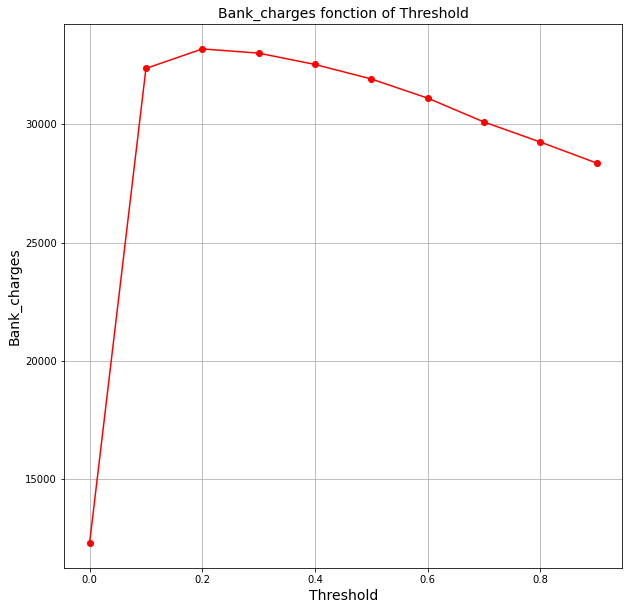

In [315]:
Threshold= list_des_seuils
Bank_charges = Bank_charges

plt.figure(figsize= (10,10)).clf()  
plt.plot(Threshold, Bank_charges, color='red', marker='o')
plt.title('Bank_charges fonction of Threshold', fontsize=14)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Bank_charges', fontsize=14)
plt.grid(True)
plt.show()


## Global Interpretability 

In [207]:
x_train=X_training.loc[0:3000]
y_y_train = y_training.loc[0:3000]

x_test=X_testing.iloc[0:1000]
y_y_test = y_test[0:1000]

NameError: name 'X_training' is not defined

In [ ]:
def roc_from_scratch(probabilities, y_test, partitions=100):
    roc = np.array([])
    for i in range(partitions + 1):
        
        threshold_vector = np.greater_equal(probabilities, i / partitions).astype(int)
        tpr, fpr = true_false_positive(threshold_vector, y_test)
        roc = np.append(roc, [fpr, tpr])
        
    return roc.reshape(-1, 2)

## Interpretability for LightGBM model by feature importance calculation

In [581]:
perm_importance = permutation_importance(model_lightgbm, x_test, y_y_test)
perm_importance_mean = perm_importance.importances_mean
sorted_idx = perm_importance.importances_mean.argsort()
feature_names = X_train.columns
features = np.array(X_test.columns)
features[sorted_idx]

array(['NAME_FAMILY_STATUS_Separated', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'FLAG_OWN_CAR',
       'NAME_HOUSING_TYPE_House / apartment',
       'LIVE_REGION_NOT_WORK_REGION', 'FLAG_DOCUMENT_7',
       'REG_REGION_NOT_WORK_REGION', 'FLAG_DOCUMENT_6',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'REG_CITY_NOT_WORK_CITY',
       'AMT_REQ_CREDIT_BUREAU_MON', 'FLAG_DOCUMENT_10', 'FLAG_PHONE',
       'FLAG_DOCUMENT_9', 'FLAG_WORK_PHONE', 'NAME_INCOME_TYPE_nan',
       'NAME_FAMILY_STATUS_Civil marriage', 'FLAG_CONT_MOBILE',
       'FLAG_DOCUMENT_19', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'FLAG_DOCUMENT_14', 'DAYS_ID_PUBLISH', 'LIVE_CITY_NOT_WORK_CITY',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'NAME_FAMILY_STATUS_Unknown',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_3', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Offic

Text(0, 0.5, 'feature names')

<Figure size 432x288 with 0 Axes>

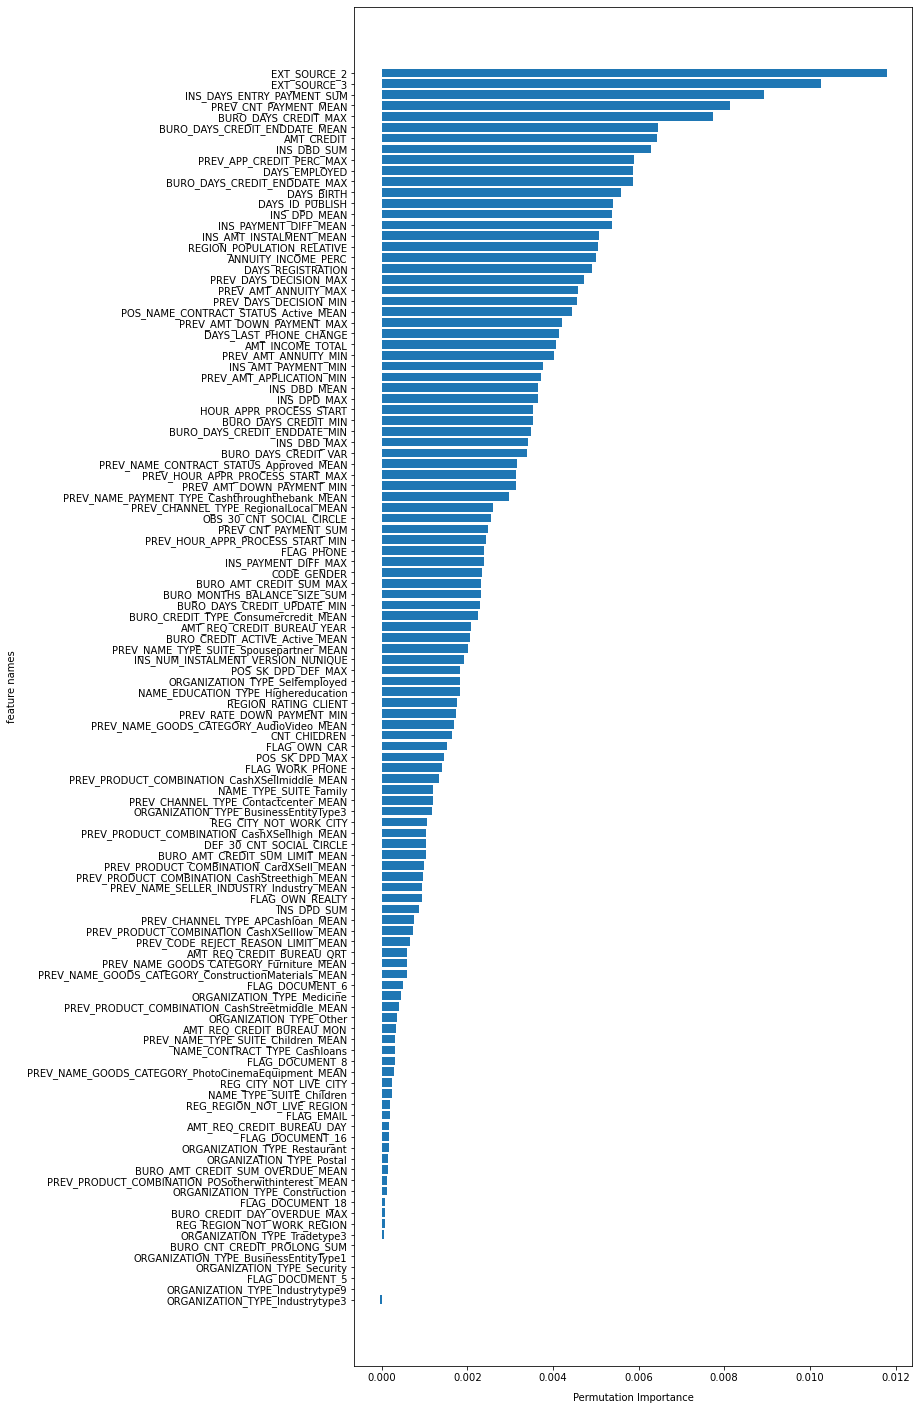

In [314]:
fig = plt.figure()
plt.figure(figsize = [10, 25])
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance", labelpad= 10)
plt.ylabel("feature names",labelpad= 10)

## Local interpretability for LightGBM model with LIME - Local Interpretable Model-Agnostic Explanations

In [8]:
x_train=X_training.loc[0:3000]
y_y_train = y_training.loc[0:3000]

x_test=X_testing.iloc[0:1000]
y_y_test = y_test[0:1000]

In [584]:
model_lightgbm_preds = model_lightgbm.predict(x_test)

In [202]:
# print("Test  Accuracy : %.2f"%model_lightgbm.score(x_test, y_y_test))
# print("Train Accuracy : %.2f"%model_lightgbm.score(x_train, y_y_train))
# print()
# print("Confusion Matrix : ")
# print(confusion_matrix(y_y_test, model_lightgbm_preds))
# print()
# print("Classification Report")
# print(classification_report(y_y_test, model_lightgbm_preds))

In [613]:
#pip install lime

Note: you may need to restart the kernel to use updated packages.


In [9]:
# import lime
# from lime import lime_tabular
explainer = lime_tabular.LimeTabularExplainer(training_data =x_train.values,
                                              feature_names=x_train.columns.values,
                                              class_names =['Non_defaulter_0','Defaulter_1'],
                                              mode="classification",
                                             verbose=True,
                                             random_state=10)

explainer

In [21]:

num=1
test_sample=x_test.iloc[num,:]
lim_exp =explainer.explain_instance(data_row=test_sample_array,
                                   predict_fn=model_lightgbm.predict_proba,
                                    num_features=20)

Intercept 0.3367978398476893
Prediction_local [1.03553107]
Right: 0.013086158568824826


In [40]:
print(lim_exp)

    Correlations= to the label 0 are explained in RED
    Correlations= to the label 1  are explained in GREEN
    So we see which are the features that contribute for this test sample for becoming a part of  defaulter(=1) or non defaulter(=0)

### Next , lets export the coefficients to understand each feature's contribution to the output

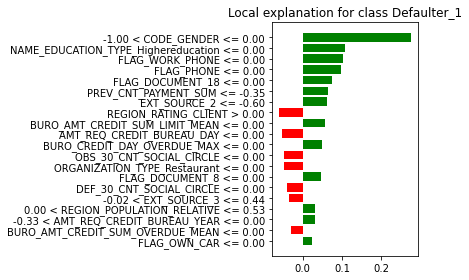

In [14]:
# Plotting the results 

plt=lim_exp.as_pyplot_figure()
plt.tight_layout()

In [95]:
 # This function returns the list of tuples for val = id_client
def get_value(val,my_dict):
    for key,value in my_dict.items():
        if val == key:
            return value 

def get_lime_weights(id_client):
    
    weights = []
    #Create DataFrame

    #Get explanation
    exp = lim_exp
    # returns a dictionary of list of tuples {1: [(0, 0.2595477001301397),(12, -0.10418098817904746),...(52, -0.0487838001049165)]}
    # for the id_client =1
    exp_dict = exp.as_map() 
    # This retuns the list of tuples 
    exp_list = get_value(id_client,exp_dict)
     
    # exp_list = sorted(exp_list, key=lambda x: x[0])
    # exp_weight = [x[1] for x in exp_list]
    #Get weights
    
    weights.append(exp_list)
    #Create DataFrame
    lime_weights = pd.DataFrame(data=weights,columns=X_testing.columns)
    
    return lime_weights

In [96]:
get_lime_weights(1)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,INS_DPD_MEAN,INS_DPD_SUM,INS_DBD_MAX,INS_DBD_MEAN,INS_DBD_SUM,INS_PAYMENT_DIFF_MAX,INS_PAYMENT_DIFF_MEAN,INS_AMT_INSTALMENT_MEAN,INS_AMT_PAYMENT_MIN,INS_DAYS_ENTRY_PAYMENT_SUM
0,"(0, 0.25977436532019477)","(37, 0.1146384841888695)","(60, -0.10257966074050466)","(12, -0.0901856818321634)","(11, 0.08163785599195576)","(21, -0.06471076086036233)","(61, 0.06129979759390291)","(54, 0.05495229421649228)","(45, -0.050078649891280594)","(42, -0.0495269829598599)",...,"(48, -0.0008725155379128782)","(107, 0.0007600681297867659)","(86, -0.0006744192844960995)","(96, -0.0006052748233437403)","(26, -0.0005643999121490508)","(67, 0.0005144994796959695)","(40, 0.0005010965629753851)","(83, -0.0004953502894906091)","(10, -0.00041218508895659396)","(34, 0.0)"


In [661]:
weights = []
#Create DataFrame

#Iterate over first 100 rows in feature matrix
for x in X_testing.values[0:100]:
    
    #Get explanation
    exp = lim_exp
    exp_list = exp.as_map()[1]
    exp_list = sorted(exp_list, key=lambda x: x[0])
    exp_weight = [x[1] for x in exp_list]
    #Get weights
    
    weights.append(exp_weight)
    #Create DataFrame
    lime_weights = pd.DataFrame(data=weights,columns=X_testing.columns)

In [651]:
# A dataframe of Weights of features (importance of features) for each client
lime_weights.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cashloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_EDUCATION_TYPE_Highereducation,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Industrytype3,ORGANIZATION_TYPE_Industrytype9,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Tradetype3,ANNUITY_INCOME_PERC,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_VAR,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_CNT_CREDIT_PROLONG_SUM,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_DAYS_CREDIT_UPDATE_MIN,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_TYPE_Consumercredit_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_APPLICATION_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_RATE_DOWN_PAYMENT_MIN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_NAME_PAYMENT_TYPE_Cashthroughthebank_MEAN,PREV_CODE_REJECT_REASON_LIMIT_MEAN,PREV_NAME_TYPE_SUITE_Children_MEAN,PREV_NAME_TYPE_SUITE_Spousepartner_MEAN,PREV_NAME_GOODS_CATEGORY_AudioVideo_MEAN,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_CATEGORY_PhotoCinemaEquipment_MEAN,PREV_CHANNEL_TYPE_APCashloan_MEAN,PREV_CHANNEL_TYPE_Contactcenter_MEAN,PREV_CHANNEL_TYPE_RegionalLocal_MEAN,PREV_NAME_SELLER_INDUSTRY_Industry_MEAN,PREV_PRODUCT_COMBINATION_CardXSell_MEAN,PREV_PRODUCT_COMBINATION_CashStreethigh_MEAN,PREV_PRODUCT_COMBINATION_CashStreetmiddle_MEAN,PREV_PRODUCT_COMBINATION_CashXSellhigh_MEAN,PREV_PRODUCT_COMBINATION_CashXSelllow_MEAN,PREV_PRODUCT_COMBINATION_CashXSellmiddle_MEAN,PREV_PRODUCT_COMBINATION_POSotherwithinterest_MEAN,POS_SK_DPD_MAX,POS_SK_DPD_DEF_MAX,POS_NAME_CONTRACT_STATUS_Active_MEAN,INS_NUM_INSTALMENT_VERSION_NUNIQUE,INS_DPD_MAX,INS_DPD_MEAN,INS_DPD_SUM,INS_DBD_MAX,INS_DBD_MEAN,INS_DBD_SUM,INS_PAYMENT_DIFF_MAX,INS_PAYMENT_DIFF_MEAN,INS_AMT_INSTALMENT_MEAN,INS_AMT_PAYMENT_MIN,INS_DAYS_ENTRY_PAYMENT_SUM
0,0.269559,0.004188,0.001634,-0.015356,-0.012352,0.03355,-0.014035,-0.005957,-0.001986,-0.011531,0.007583,0.095275,-0.097906,0.021748,0.058598,0.02348,-0.028682,-0.008767,-0.007691,0.007129,0.030022,-0.059126,-0.041742,-0.037229,-0.007891,-0.021349,-0.029738,0.047963,0.047861,0.008756,-0.022714,0.004072,0.005185,0.030304,0.0,-0.041448,-0.003387,0.118799,-0.001279,-0.01238,-0.031701,0.001595,0.007377,0.018358,0.008116,0.058118,0.025641,0.051834,0.012279,-0.020314,-0.01183,0.003178,-0.054304,0.001405,0.059087,0.003586,0.027638,-0.012483,0.031868,0.004029,-0.082918,0.053953,-0.002566,0.0113,0.007015,-0.001229,-0.002775,0.000285,-0.024491,0.020656,-0.017975,-0.029591,0.007003,-0.013205,-0.027936,0.000207,-0.009141,-0.024863,-0.036064,-0.005862,0.007266,0.000314,-0.004552,-0.015614,-0.012248,-0.02854,0.016976,0.025956,-0.022341,-0.021773,0.01976,0.009135,0.005146,0.003609,-0.004247,0.004814,-0.012185,-0.008612,-0.006858,0.002837,-0.002649,0.019638,-0.013031,-0.015515,0.00

## Further improving the classificationt with Neaural Networks training

In [ ]:

# from keras.models import Sequential
# from keras.layers import Dense
 
model = Sequential() 
model.add(Dense(512, activation='relu', input_dim=117))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

In [ ]:
	
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=100)


In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns
# sns.set()
 
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [ ]:
y_predicted = model.predict(X_test) > 0.5
mat = confusion_matrix(y_test, y_predicted)
labels = ['Legitimate', 'Fraudulent']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [ ]:
X_test.shape

In [ ]:
X_test.sample(200).to_csv('app_x_test.csv', index=False)

In [ ]:
xg_joblib_model = joblib.load('xgb_model_joblib')

In [ ]:
xg_joblib_model.predict(X_test.head(1))

In [245]:
# # # Load the data 
# x_test.to_csv('./x_test.csv', index=False)
# y_y_test.to_csv('./y_y_test.csv', index = False)
# x_train.to_csv('./x_train.csv', index = False)
# y_y_train.to_csv('./y_y_train.csv', index = False)

In [247]:
# X_res=pd.read_csv('./X_res.csv')
# y_test=pd.read_csv('./y_test.csv')
# x_test.to_csv('./x_test.csv', index=False)
# y_y_test.to_csv('./y_y_test.csv', index = False)

In [283]:

# #x_training=X_res.iloc[0:10000]
# y_training=y_res[0:10000]['TARGET']
# #x_tessting=X_testing.iloc[0:3000]
# y_testing=y_test[0:3000]['TARGET']

In [293]:
# # # Load the data 
# #x_training.to_csv('./x_training.csv', index=False)
# y_training.to_csv('./y_training.csv', index = False)
# #x_testing.to_csv('./x_testing.csv', index = False)
# y_testing.to_csv('./y_testing.csv', index = False)